In [139]:
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 150)
import seaborn as sns
sns.set_theme(color_codes=True)
from scipy import stats
import statsmodels.api as sm
import numpy as np
import json

## Read the Data

In [140]:
first_session_raw_data = pd.read_csv('Data/gono-go-game-first-round.csv', index_col=0).reset_index()
# first_session_raw_data = first_session_raw_data[first_session_raw_data['recorded_at'] > '2022-01-18']

num_all_experimenters = len(first_session_raw_data.mturkID.unique())
num_excluded_experimenters = 0

first_session_raw_data['correct'] = first_session_raw_data.correct == 'true'
first_session_raw_data.head()

/opt/homebrew/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (32,65) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,run_id,condition,rt,url,trial_type,trial_index,time_elapsed,internal_node_id,experiment_id,assignmentID,mturkID,hitID,exp_final_status,success,timeout,failed_images,failed_audio,failed_video,stimulus,response,exp_stage,view_history,exp_part,question_order,quiz_score,recorded_at,ip,user_agent,device,browser,browser_version,platform,platform_version,source_code_version,focus_screen,color,cond,cond_action,cond_outcome,block,side,x_circle,y_circle,choice,correct,curr_bonus,trial_bonus,outcome,feedback_points,prob_fall,expected_feedback,agg_fb_pts,hitId,workerId,assignmentId,a,tp_a,b,tp_b,c,tp_c,error_block,num_gos,num_nogos,suspicious,suspicious_type
0,10,1,1429.1999999955297,https://raw.githubusercontent.com/Sepsad/Ortho...,external-html,0,1440,0.0-0.0,GNG_ev45gnlk,"""","""","""",not_completed_by_failing_quiz,"""","""","""","""","""","""","""","""","""","""","""","""",2021-11-12 15:05:54,95.217.7.68,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Macintosh,Chrome,95.0.4638.69,OS X,10_15_7,ff253546778cd407e57361676f185c6a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10,1,1251.1999999955297,https://raw.githubusercontent.com/Sepsad/Ortho...,external-html,1,2703,0.0-1.0,GNG_ev45gnlk,"""","""","""",not_completed_by_failing_quiz,"""","""","""","""","""","""","""","""","""","""","""","""",2021-11-12 15:05:54,95.217.7.68,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Macintosh,Chrome,95.0.4638.69,OS X,10_15_7,ff253546778cd407e57361676f185c6a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,1,"""","""",preload,2,3543,0.0-2.0,GNG_ev45gnlk,"""","""","""",not_completed_by_failing_quiz,true,false,[],[],[],"""","""","""","""","""","""","""",2021-11-12 15:05:54,95.217.7.68,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Macintosh,Chrome,95.0.4638.69,OS X,10_15_7,ff253546778cd407e57361676f185c6a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,1,977.1000000014901,"""",html-button-response,3,4522,0.0-3.0,GNG_ev45gnlk,"""","""","""",not_completed_by_failing_quiz,"""","""","""","""","""",<img src='../img/welcome.gif' style='height: 2...,0,first_welcome,"""","""","""","""",2021-11-12 15:05:54,95.217.7.68,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Macintosh,Chrome,95.0.4638.69,OS X,10_15_7,ff253546778cd407e57361676f185c6a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10,1,3232.89999999851,"""",instructions,4,7756,0.0-4.0,GNG_ev45gnlk,"""","""","""",not_completed_by_failing_quiz,"""","""","""","""","""","""","""",before_instructions,"[{""page_index"":0,""viewing_time"":713},{""page_in...",before_instructions,"""","""",2021-11-12 15:05:54,95.217.7.68,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Macintosh,Chrome,95.0.4638.69,OS X,10_15_7,ff253546778cd407e57361676f185c6a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
len(first_session_raw_data.mturkID.unique())

233

In [142]:
# for i in list(set(first_session_clean_data.mturkID.unique()) - set(susp.mturkID.value_counts()[ (susp.mturkID.value_counts() == 3) ].index)):
#     print(i)

# Apply exclusion criteria

1. Fail the quiz of instructions more than twice.
2. Change the tab or window of the experiment.

In [143]:
first_session_clean_data = first_session_raw_data[(first_session_raw_data.exp_final_status == 'fully_completed')]

num_excluded_experimenters = len(first_session_raw_data.mturkID.unique()) - len(first_session_clean_data.mturkID.unique())

print("Number of participants excluded by this criterias:", num_excluded_experimenters)

Number of participants excluded by this criterias: 31


3. Respond randomly, always go or never go.

    * Note: We exclude who repond randomly, always go or nogo in each 3 block

In [144]:
first_session_clean_data.mturkID.unique().shape

(202,)

In [145]:
IDs_for_exclusion_by_random_response = []
IDs_for_exclusion_by_random_response = list(susp.mturkID.value_counts()[ (susp.mturkID.value_counts() == 3) ].index)



num_excluded_experimenters += len(IDs_for_exclusion_by_random_response)

first_session_clean_data = first_session_clean_data[first_session_clean_data.isin(IDs_for_exclusion_by_random_response) == False]

print("Number of participants excluded by this criterias:", len(IDs_for_exclusion_by_random_response))


Number of participants excluded by this criterias: 12


4. Their rate of the correct response to detection of circle side task is less than 55%.

In [146]:
circle_side_correctness = first_session_clean_data[first_session_clean_data.choice == 'go'][['mturkID','side', 'response']]
circle_side_correctness['is_correct_circle_side'] =  (circle_side_correctness.side == circle_side_correctness.response)
accuracy_data = circle_side_correctness.groupby('mturkID').mean().reset_index()
accuracy_data.columns = ['mturkID', 'rate']
accuracy_data['is_below_55'] = accuracy_data.rate < 0.55


In [147]:
non_accurate_IDs = accuracy_data[accuracy_data.is_below_55].mturkID

num_excluded_experimenters += len(non_accurate_IDs)

first_session_clean_data = first_session_clean_data[first_session_clean_data.isin(list(non_accurate_IDs)) == False]
print("Number of participants excluded by this criterias:", len(non_accurate_IDs))



Number of participants excluded by this criterias: 44


# Plot Perforance per conditions

/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_61727/1135958102.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  circle_task_logs['correct_action'] = (circle_task_logs.choice == circle_task_logs.cond_action)


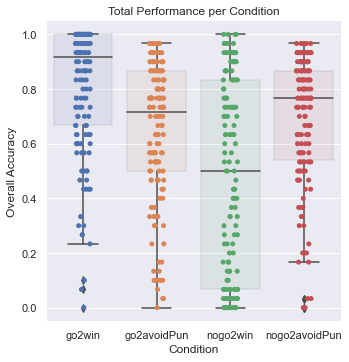

In [148]:
mapping = {'1': 'go2win', '2': 'nogo2win', '3': 'go2avoidPun', '4' : 'nogo2avoidPun'} 

circle_task_logs = first_session_clean_data[first_session_clean_data.exp_stage == 'main_target_detection']

circle_task_logs['correct_action'] = (circle_task_logs.choice == circle_task_logs.cond_action)
performance_per_condition = circle_task_logs.groupby(['mturkID','cond']).mean().reset_index()
performance_per_condition.cond = performance_per_condition.cond.map(mapping)

ax = sns.catplot(x="cond", y="correct", data=performance_per_condition, order= ['go2win','go2avoidPun' ,'nogo2win', 'nogo2avoidPun']);
ax = sns.boxplot(x="cond", y="correct", data= performance_per_condition, boxprops=dict(alpha=.1), order= ['go2win','go2avoidPun' ,'nogo2win', 'nogo2avoidPun']);

ax.set(xlabel="Condition", ylabel = "Overall Accuracy", title = 'Total Performance per Condition')
plt.show()


# NoGO 2 Win Performance Dist.

<AxesSubplot:ylabel='Frequency'>

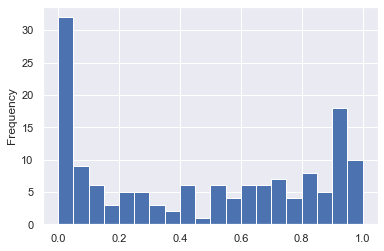

In [149]:
performance_per_condition[performance_per_condition.cond == 'nogo2win'].correct.plot(kind='hist', bins = 20)

# Extract demographic data

In [150]:
raw_demographic_data = first_session_clean_data[first_session_clean_data.trial_type == 'survey-html-form'][['mturkID', 'response']]
raw_demographic_data['gender'] = raw_demographic_data.response.apply(lambda x: x.split('"')[3])
raw_demographic_data['age'] = raw_demographic_data.response.apply(lambda x: x.split('"')[7])
raw_demographic_data['education_level'] = raw_demographic_data.response.apply(lambda x: x.split('"')[11])
raw_demographic_data['comments'] = raw_demographic_data.response.apply(lambda x: x.split('"')[15])
raw_demographic_data = raw_demographic_data.drop(['response'], axis=1)
raw_demographic_data.head()

,mturkID,gender,age,education_level,comments
859,A8028AFBBS29G,female,66,High,Yes I wanted to remember which to push and whi...
2560,A1FVXS8IM5QYO8,female,55,High,This was a really interesting task
3367,AD1WGUMVD6KED,female,39,High,Everything was straight forward and ran smooth...
4174,A353XKDTUX10NC,male,27,High,}
4991,NaN,male,33,Bachelor,n/a


# Create final data to analyze

In [151]:
final_performace_data = performance_per_condition.pivot(index='mturkID', columns='cond', values='correct').reset_index()

final_performace_data = pd.merge(final_performace_data, accuracy_data, on='mturkID', how='left')
final_performace_data = pd.merge(final_performace_data, raw_demographic_data, on='mturkID')
final_performace_data.columns = ['mturkID', 'go2avoidPun_first_session', 'go2win_first_session', 'nogo2avoidPun_first_session', 'nogo2win_first_session', 'circle_side_performance_first_session',\
       'is_below_55_first_session', 'gender_first_session', 'age_first_session', 'education_level_first_session', 'comments_first_session']

final_performace_data.head()

,mturkID,go2avoidPun_first_session,go2win_first_session,nogo2avoidPun_first_session,nogo2win_first_session,circle_side_performance_first_session,is_below_55_first_session,gender_first_session,age_first_session,education_level_first_session,comments_first_session
0,A10BH9PYCYUKDJ,0.100000,1.000000,0.833333,0.300000,0.983871,False,female,41,Associate,None
1,A10JXOU89D5RXR,0.800000,1.000000,0.833333,0.000000,1.000000,False,female,60,Bachelor,none
2,A10M63DSIGIEDI,0.466667,0.633333,0.000000,0.033333,0.610687,False,male,25,Bachelor,None
3,A11S8IAAVDXCUS,0.733333,1.000000,0.966667,0.033333,1.000000,False,female,31,Associate,}
4,A12FTSX85NQ8N9,0.566667,0.500000,0.866667,0.866667,0.895833,False,male,29,Bachelor,}


In [167]:
final_performace_data['is_learned'] = final_performace_data.overall_performance > 0.65
final_performace_data['is_learned'] = final_performace_data['is_learned'].replace({True:'learned', False:'not_learned'})
final_performace_data['is_learned'].value_counts()

not_learned    73
learned        73
Name: is_learned, dtype: int64

# Pavlovian Axis 
### learned individualas are those who their OVERALL PERFORMANCE > 0.65

Text(0.5, 1.0, 'nogo2avoidPun')

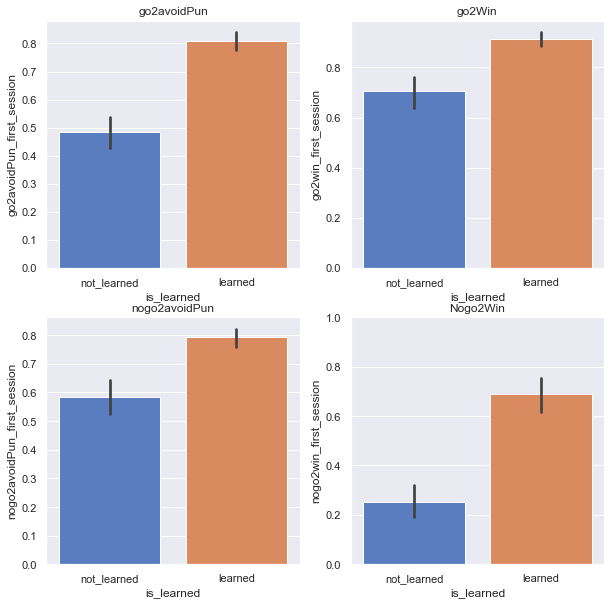

In [168]:
fig, axs = plt.subplots(ncols=2, nrows = 2, figsize=(10,10))
plt.ylim(0, 1)

sns.barplot(x="is_learned", y="nogo2win_first_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(1,1)]).set_title('Nogo2Win')

sns.barplot(x="is_learned", y="go2win_first_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(0,1)]).set_title('go2Win')


sns.barplot(x="is_learned", y="go2avoidPun_first_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(0,0)]).set_title('go2avoidPun')


sns.barplot(x="is_learned", y="nogo2avoidPun_first_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(1,0)]).set_title('nogo2avoidPun')



# (NoGo2 )

<AxesSubplot:>

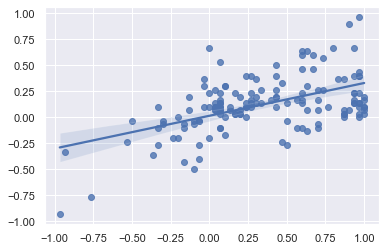

In [164]:
sns.regplot( x = -(final_performace_data['nogo2win_first_session'] - final_performace_data['go2win_first_session']),
             y = -(final_performace_data['nogo2avoidPun_first_session'] - final_performace_data['go2win_first_session']))

<AxesSubplot:xlabel='nogo2win_first_session'>

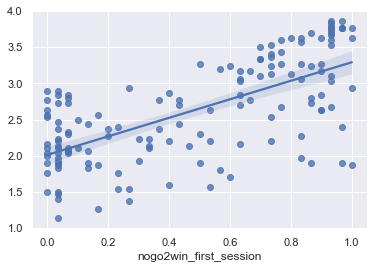

In [156]:
overall_performance =  final_performace_data['nogo2win_first_session'] + \
                        final_performace_data['go2win_first_session'] + \
                        final_performace_data['nogo2avoidPun_first_session'] + \
                        final_performace_data['go2avoidPun_first_session']
final_performace_data['overall_performance'] = overall_performance/4

sns.regplot( x = final_performace_data['nogo2win_first_session'],
             y = overall_performance)

             

<AxesSubplot:xlabel='nogo2avoidPun_first_session'>

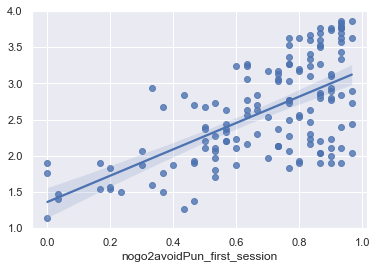

In [157]:
sns.regplot( x = final_performace_data['nogo2avoidPun_first_session'],
             y = overall_performance)

In [158]:
# np.corrcoef(final_performace_data['nogo2win_first_session'] - final_performace_data['go2win_first_session'], final_performace_data['nogo2avoidPun_first_session'] - final_performace_data['go2win_first_session'])

stats.pearsonr(final_performace_data['nogo2win_first_session'] - final_performace_data['go2win_first_session'], final_performace_data['nogo2avoidPun_first_session'] - final_performace_data['go2win_first_session'])

(0.5232120181104403, 1.241447138938456e-11)

<AxesSubplot:xlabel='go2win_first_session', ylabel='nogo2avoidPun_first_session'>

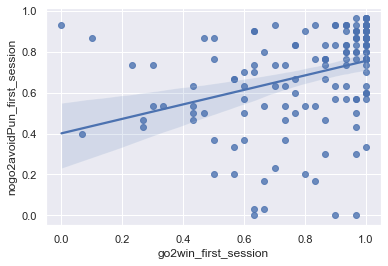

In [159]:
sns.regplot( x = final_performace_data['go2win_first_session'] ,
             y = final_performace_data['nogo2avoidPun_first_session'] )

In [163]:
final_performace_data.to_csv('Data/first_round_final_performance.csv')